In [6]:
from vesicle_picker import (
    preprocess,
    generate_masks,
    postprocess,
    helpers,
    external_import,
    external_export,
    funcs_mrcio
)
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter
from scipy.interpolate import splprep, splev

/home/ptclfocuser/software/home/software/anaconda3/envs/vesicle-picker-samhq/lib/python3.9/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/ptclfocuser/software/home/software/anaconda3/envs/vesicle-picker-samhq/lib/python3.9/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/home/ptclfocuser/software/home/software/anaconda3/envs/vesicle-picker-samhq/sam-hq/segment_anything/modeling/tiny_vit_sam.py:662: UserWarning: Overwriting tiny_vit_5m_224 in registry with segment_anything.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please

# Set parameters

In [7]:
psize_A = 0.8189
contour_spacing = 50 # Separation between points in A
hist_endpoints = 90 # Distance in A for histogram to extend from membrane
first_clean_cutoff = 15 # Maximum distance in A to permit picks to deviate from their neighbours in first cleaning step
second_clean_cutoff = 60 # Maximum distance in A to permit picks to deviate from their neighbours in second cleaning step
spline_density = 1000
support_separation = 200

# Part 1: Generate vesicle masks
## Option 1
Compute and filter masks from a micrograph.

### Option 1a
Load micrographs from a local file.

In [8]:
# Define an import function
def import_mrc(filename):
    """Use funcs_mrcio to open a specified .mrc file"""
    # Read the .mrc file in binary
    micrograph = open(filename, 'rb')

    # Use funcs_mrcio to extract image array and
    # rescale values to lie between [-1, 1]
    image = funcs_mrcio.irdsec_opened(micrograph, 0)

    # Use funcs_mrcio to extract header info
    header = funcs_mrcio.irdhdr_opened(micrograph)

    # Return the rescaled image and header
    return image, header

In [9]:
# Import the example mrc
image_fullres, header = import_mrc("/media/ptclfocuser/QCRG2BigSSD2/Katrina/20240703_Krios1_EGFR_NEM_CDV/CS-egfr-cdv-nem/J1/imported/000865937328793186922_blackk_20240703_EGFR_NEM_CDV_collect_3_150-20_00055_aligned_mic_DW.mrc")
image_fullres = image_fullres.T

### Option 1b
Load micrographs from a cryosparc extract picks job.

In [28]:
# Pull the micrographs object from cryosparc
cs = external_import.load_cryosparc("/media/ptclfocuser/QCRG2BigSSD2/Isaiah/vesicle_picker_demo/params/csparc_login.ini")
micrographs = external_import.micrographs_from_csparc(
    cs=cs,
    project_id="P17",
    job_id="J969",
    job_type="curate"
)
project = cs.find_project("P17")

Connection succeeded to CryoSPARC command_core at http://ptclfocuser-desktop:39002
Connection succeeded to CryoSPARC command_vis at http://ptclfocuser-desktop:39003
Connection succeeded to CryoSPARC command_rtp at http://ptclfocuser-desktop:39005


/home/ptclfocuser/software/home/software/anaconda3/envs/vesicle-picker-samhq/vesicle-picker/vesicle_picker/external_import.py:29: UserWarning: CryoSPARC instance ptclfocuser-desktop:39000 with version v4.5.3 may not be compatible with current cryosparc-tools version v4.6.0.

To install a compatible version of cryosparc-tools:

    pip install --force cryosparc-tools~=4.5.0

Or, if running a CryoSPARC pre-release or private beta:

    pip install --no-cache --force https://github.com/cryoem-uoft/cryosparc-tools/archive/refs/heads/develop.zip

  cs = CryoSPARC(


In [31]:
# Isolate one micrograph of choice
micrograph = micrographs[2]
header, image_fullres = project.download_mrc(micrograph["micrograph_blob/path"])
image_fullres = image_fullres[0]

### Continuing Step 1
Regardless of import method, load the SAM-HQ model and generate masks.

(-0.5, 1439.5, 1022.5, -0.5)

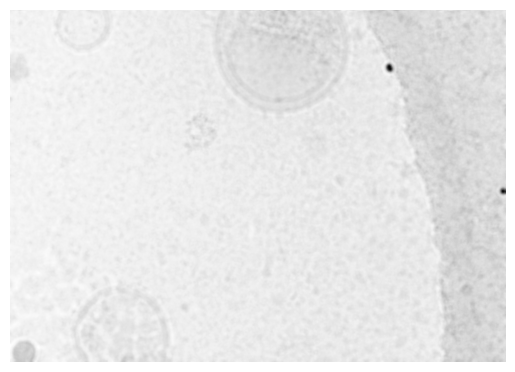

In [32]:
# Use the preprocess module to get micrograph ready for segmentation
preprocessed_micrograph = preprocess.preprocess_micrograph(
    image_fullres,
    downsample=4,
    lowpass_mode="bilateral",
    d=17,
    sigmaColor=71,
    sigmaSpace=71
)

# Display the preprocessed micrograph
plt.imshow(preprocessed_micrograph, cmap="Greys_r")
plt.axis('off')

In [11]:
# Use the generate_masks module to perform automatic image segmentation
# Initialize the model
model = generate_masks.initialize_model(
    model_weights_path="/home/ptclfocuser/software/home/software/anaconda3/envs/vesicle-picker-samhq/vesicle-picker/sam_hq_vit_h.pth",
    device='cuda'
)

<All keys matched successfully>


In [33]:
# Generate masks with user-optimized parameters
masks = generate_masks.generate_masks(
    preprocessed_micrograph,
    model,
    points_per_side=36,
    points_per_batch=16,
    pred_iou_thresh=0.9,
    stability_score_thresh=0.9,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    crop_nms_thresh=0.1,
    min_mask_region_area=100,
    psize=1.07,
    downsample=4
)

In [44]:
# Use the postprocess module to compute statistics on the vesicles
postprocessed_masks = postprocess.postprocess_masks(
    masks,
    [
        postprocess.find_mask_intensity,
        postprocess.find_contour,
        postprocess.find_roundness,
        postprocess.fit_ellipse
    ],
    preprocessed_micrograph
)

# Filter these vesicles based on min and max values recorded in 'filters.ini'
# "../../../vesicle-picker/tests_KAB/filters.ini"
filtered_masks = postprocess.apply_filters(postprocessed_masks, "/media/ptclfocuser/QCRG2BigSSD2/Isaiah/czi_samples/filters.ini")

# Use the extract_statistics function to generate Pandas Dataframes
# of the postprocessed values, for downstream analysis.
unfiltered_dataset, filtered_dataset = (
    postprocess.extract_statistics(postprocessed_masks, "/media/ptclfocuser/QCRG2BigSSD2/Isaiah/czi_samples/filters.ini")
)

pd.DataFrame(filtered_dataset)

,area,roundness
0,92251,0.813922
1,7275,0.767991
2,3562,0.804476
3,17421,0.812228
4,3443,0.905328


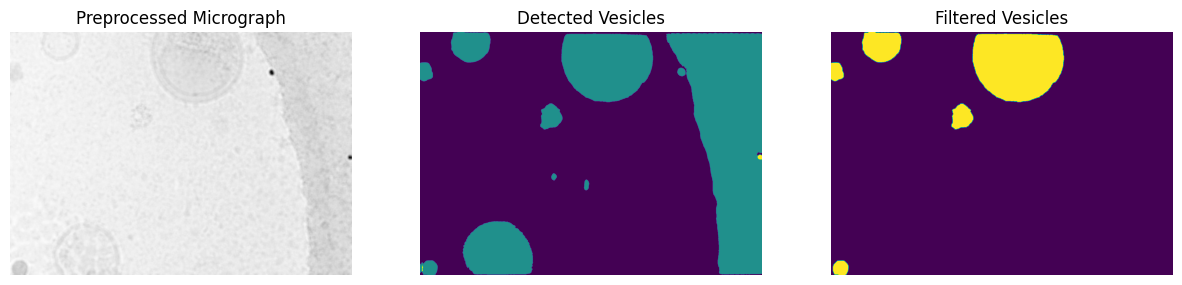

In [45]:
# Create a figure with three subplots arranged in a row
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image in the first subplot
axes[0].imshow(preprocessed_micrograph, cmap="Greys_r")
axes[0].set_title('Preprocessed Micrograph')

# Plot the second image in the second subplot
axes[1].imshow(helpers.sum_masks(masks, 'segmentation'))
axes[1].set_title('Detected Vesicles')

# # Plot the third image in the third subplot
axes[2].imshow(helpers.sum_masks(filtered_masks, 'segmentation'))
axes[2].set_title('Filtered Vesicles')

# Remove axis labels and ticks
for ax in axes:
    ax.axis('off')

### Save masks from Option 1
Optionally, save masks generated by the model to disk.

In [11]:
external_export.export_masks_to_disk(filtered_masks, 
                                     "/media/ptclfocuser/QCRG2BigSSD2/Isaiah/czi_samples/masks_blackk_20240703_EGFR_NEM_CDV_collect_3_150-20_00055_aligned_mic_DW.plk",
                                     micrograph_uid=0,
                                     compression="uint64")

## Option 2
Load masks from a file on disk.

In [ ]:
filtered_masks = external_import.import_masks_from_disk("/media/ptclfocuser/QCRG2BigSSD2/Isaiah/czi_samples/masks_blackk_slot9_VLP_EGFR_14_0003_Nov04_aligned_mic_DW.plk")

# Part 2: Generate Membrane Picks

In [46]:
# Generate vesicle edges
masks_edges = [postprocess.find_contour(mask) for mask in filtered_masks]
# Extract contours and upsample to original image coordinates
masks_edges = [edges["contours"][0].squeeze(1) * 4 for edges in masks_edges]

In [ ]:
# Optional: After generating splines, return here and run this code to set those splines as the mask edges and repick from those
# masks_edges = [splines[i] for i in range(2, len(splines), 3)]
# masks_edges = [[np.array(particle) for particle in edge] for edge in masks_edges]

In [47]:
# Downsample the vesicle picks to the given nm separation
def downsample_particles(particles, dist):
    particles_downsampled = [particles[0]]
    for particle in particles:
        if np.linalg.norm(particle - particles_downsampled[-1]) * psize_A >= dist:
            particles_downsampled.append(particle)
    return particles_downsampled

# Downsample vesicle edges
masks_edges_downsampled = [downsample_particles(edges, contour_spacing) for edges in masks_edges]

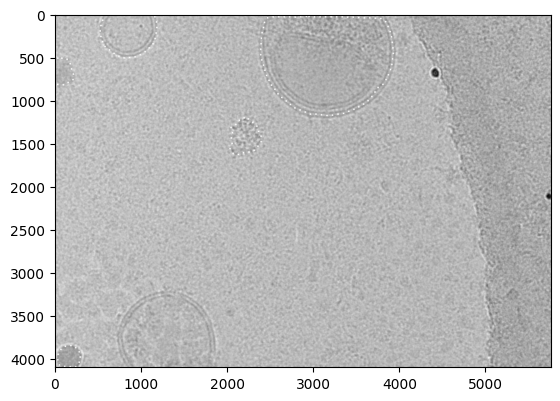

In [48]:
blurred_image = cv2.GaussianBlur(image_fullres, (29, 29), 5, 5)
img_temp = np.copy(blurred_image)
img_temp_max = np.max(img_temp)
for edges in masks_edges_downsampled:
    for particle in edges:
        for i in range(-8, 9):
            for j in range(-8, 9):
                if 0 <= particle[1] + i < img_temp.shape[0] and 0 <= particle[0] + j < img_temp.shape[1]:
                    img_temp[(particle[1] + i, particle[0] + j)] = img_temp_max
plt.imshow(img_temp, cmap="gray")
plt.show()

In [49]:
def sign(x):
    if x == 0:
        return 0
    return int(abs(x) / x)

def is_pixel_in_square(corners, row, col):
    # Precondition: corners given in traversible order (clockwise or counterclockwise)
    # Compute determinant of edge to point transformation: positive if clockwise, negative otherwise
    D1 = (corners[1][0] - corners[0][0]) * (col - corners[0][1]) - (corners[1][1] - corners[0][1]) * (row - corners[0][0])
    D2 = (corners[2][0] - corners[1][0]) * (col - corners[1][1]) - (corners[2][1] - corners[1][1]) * (row - corners[1][0])
    D3 = (corners[3][0] - corners[2][0]) * (col - corners[2][1]) - (corners[3][1] - corners[2][1]) * (row - corners[2][0])
    D4 = (corners[0][0] - corners[3][0]) * (col - corners[3][1]) - (corners[0][1] - corners[3][1]) * (row - corners[3][0])
    # If the point is on different sides of both pairs of opposite lines, it is within the square
    # Negative sign reverses orientation of opposite line, use not equal to permit points on one line (D=0) 
    return (sign(D1) != sign(-D3) and sign(D2) != sign(-D4))

def pixels_in_square(p1, p2):
    # Find the pixels in a square whose upper corners are p1, p2
    # Calculate corners of the square
    d1 = p1[0] - p2[0]
    d2 = p1[1] - p2[1]
    if d2 > 0:
        s1, s2 = d2, -d1
    else: # d2 < 0
        s1, s2 = -d2, d1
    corners = (p1, p2, (p2[0] + s1, p2[1] + s2), (p1[0] + s1, p1[1] + s2))
    # Check each pixel in the bounding box of the square.
    in_square = set()
    for row in range(min(c[0] for c in corners), max(c[0] for c in corners)):
        for col in range(min(c[1] for c in corners), max(c[1] for c in corners)):
            if is_pixel_in_square(corners, row, col):
                in_square.add((row, col))
    return in_square

def pixels_in_rectangle(p1, p2):
    # Find the pixels in the 5nm by 20nm rectangular region around the two membrane points given.
    # Calculate rectangle as union of four 5nm by 5nm squares shifted from the given points.
    in_rectangle = set()
    # Calculate offset of one square
    d1 = p1[0] - p2[0]
    d2 = p1[1] - p2[1]
    if d2 > 0:
        s1, s2 = d2, -d1
    else: # d2 < 0
        s1, s2 = -d2, d1
    for i in range(-2, 2):
        in_rectangle.update(pixels_in_square((p1[0] + i * s1, p1[1] + i * s2), (p2[0] + i * s1, p2[1] + i * s2)))
    return in_rectangle


def proj_dist(p, d):
    # Compute length of projection of p onto d
    return (p[0] * d[0] + p[1] * d[1]) / ((d[0] ** 2 + d[1] ** 2) ** 0.5)

def bin_rectangle(img, p1, p2, rectangle):
    # Calculate vector pointing out of the vesicle, given points proceed clockwise
    d1 = - (p2[1] - p1[1])
    d2 = (p2[0] - p1[0])
    bins = {}
    for p in rectangle:
        if 0 <= p[1] < img.shape[0] and 0 <= p[0] < img.shape[1]:
            p_dist = int(proj_dist((p[0] - p1[0], p[1] - p1[1]), (d1, d2)) * 0.819)
            if p_dist not in bins:
                bins[p_dist] = [img[p[1]][p[0]]]
            else:
                bins[p_dist].append(img[p[1]][p[0]])
    return bins


def find_bilayers(intensities, offset):
    intensities_range = np.max(intensities) - np.min(intensities)
    pos_peaks = find_peaks(intensities, prominence=0.1 * intensities_range)[0]
    neg_peaks = find_peaks([-1 * intensity for intensity in intensities], prominence=0.1 * intensities_range)[0]
    candidates = []
    if len(neg_peaks) < 2 or len(pos_peaks) < 1: # Insufficient peaks for bilayer
        return candidates
    pos_considering = 0 # Index of positive peak under consideration
    while pos_peaks[pos_considering] < neg_peaks[0]: # Update to first positive peak after at least one negative peak
        pos_considering += 1
        if pos_considering == len(pos_peaks): # No positive peak between two negative peaks
            return candidates
    neg_considering = 0 # Index of negative peak before pos peak considered
    while pos_considering < len(pos_peaks):
        # Update closest negative peak 
        while neg_considering + 1 < len(neg_peaks) and neg_peaks[neg_considering + 1] < pos_peaks[pos_considering]:
            neg_considering += 1
        if neg_considering == len(neg_peaks) - 1: # No subsequent negative peak
            return candidates
        if 25 <= (neg_peaks[neg_considering + 1] - neg_peaks[neg_considering]) <= 45:
            # print(f"Candidate {pos_peaks[pos_considering] - 100} Separation: {neg_peaks[neg_considering + 1] - neg_peaks[neg_considering]}")
            candidates.append((neg_peaks[neg_considering] - offset, pos_peaks[pos_considering] - offset, neg_peaks[neg_considering + 1] - offset))
        pos_considering += 1
    return candidates


def update_pick(p1, p2, bilayer, psize):
    # Calculate midpoint from p1 to p2
    m1 = (p1[0] + p2[0]) / 2
    m2 = (p1[1] + p2[1]) / 2
    # Calculate vector pointing out of the vesicle, given points proceed clockwise
    d1 = - (p2[1] - p1[1])
    d2 = (p2[0] - p1[0])
    # Normalize vector out of vesicle (now 1 pixel = 0.819A)
    d_norm = (d1 ** 2 + d2 ** 2) ** 0.5
    d1 = d1 / d_norm
    d2 = d2 / d_norm
    return ((round(m1 + bilayer[0] * d1 / psize), round(m2 + bilayer[0] * d2 / psize)), 
            (round(m1 + bilayer[1] * d1 / psize), round(m2 + bilayer[1] * d2 / psize)), 
            (round(m1 + bilayer[2] * d1 / psize), round(m2 + bilayer[2] * d2 / psize)))

In [50]:
def bilayer_intensity(intensities, bilayer, offset):
    return (intensities[bilayer[0] + offset] + intensities[bilayer[2] + offset])

In [51]:
all_updated_edges = []
for edges in masks_edges_downsampled:
    updated_edges = []
    for i in range(0, len(edges) - 1):
        # For time reasons, skip pairs of contour points that are very far apart
        if np.linalg.norm(edges[i] - edges[i + 1]) * psize_A >= 1.5 * contour_spacing:
            continue
        test_rectangle = pixels_in_rectangle(edges[i], edges[i + 1])
        bins = bin_rectangle(blurred_image, edges[i], edges[i + 1], test_rectangle)
        intensities = []
        for j in range(-hist_endpoints, hist_endpoints + 1):
            if j in bins:
                intensities.append(np.mean(bins[j]))
            else:
                intensities.append(0.0)
        bilayers = find_bilayers(intensities, hist_endpoints)
        if len(bilayers) == 1:
            updated_edges.append(update_pick(edges[i], edges[i + 1], bilayers[0], psize_A))
        elif len(bilayers) > 1:
            bilayers = sorted(bilayers, key=lambda bilayer: bilayer_intensity(intensities, bilayer, hist_endpoints))
            intensities_range = np.max(intensities) - np.min(intensities)
            if bilayer_intensity(intensities, bilayers[1], hist_endpoints) - bilayer_intensity(intensities, bilayers[0], hist_endpoints) > 0.25 * intensities_range:
                updated_edges.append(update_pick(edges[i], edges[i + 1], bilayers[0], psize_A))
    all_updated_edges.append(updated_edges)

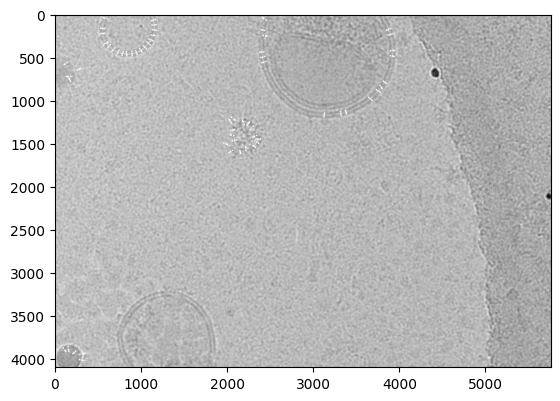

In [52]:
img_temp = np.copy(blurred_image)
img_temp_max = np.max(img_temp)
for edge in all_updated_edges:
    for particle_pair in edge:
        for particle in particle_pair:
            for i in range(-8, 9):
                for j in range(-8, 9):
                    img_temp[(particle[1] + i, particle[0] + j)] = img_temp_max
plt.imshow(img_temp, cmap="gray")
plt.show()

In [57]:
def clean_edges(edges, angle_cutoff, psize):
    updated_edges = []
    for edge in edges:
        if len(edge) < 3:
            updated_edges.append([])
            continue
        im_edge = np.array([bilayer[0] for bilayer in edge] + [edge[0][0], edge[1][0]])
        im_edge_vec1 = im_edge[1:-1] - im_edge[:-2]
        im_edge_vec2 = im_edge[2:] - im_edge[:-2]
        im_deviance = np.array([psize * proj_dist(im_edge_vec1[i], (im_edge_vec2[i][1], -im_edge_vec2[i][0])) for i in range(len(im_edge_vec1))])
        updated_edges.append([edge[i] for i in range(len(edge)) if i not in (np.where(np.abs(im_deviance) > angle_cutoff)[0] + 1)])
    return updated_edges

all_updated_edges_cleaned = clean_edges(all_updated_edges, first_clean_cutoff, psize_A)
while any(len(all_updated_edges[i]) != len(all_updated_edges_cleaned[i]) for i in range(len(all_updated_edges))):
    all_updated_edges = all_updated_edges_cleaned
    all_updated_edges_cleaned = clean_edges(all_updated_edges, second_clean_cutoff, psize_A)

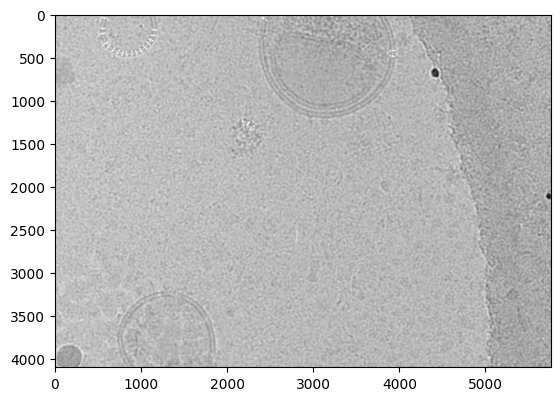

In [58]:
img_temp = np.copy(blurred_image)
img_temp_max = np.max(img_temp)
for edge in all_updated_edges_cleaned:
    for particle_pair in edge:
        for particle in particle_pair:
            for i in range(-8, 9):
                for j in range(-8, 9):
                    img_temp[(particle[1] + i, particle[0] + j)] = img_temp_max
plt.imshow(img_temp, cmap="gray")
plt.show()

# Part 3: Fit splines to membrane picks

## Option 1: Fit spline to full vesicle

In [59]:
splines = []
for edge in all_updated_edges:
    if len(edge) > 3:
        for i in range(3):
            p_x = np.array([points[i][0] for points in edge] + [edge[0][i][0]])
            p_y = np.array([points[i][1] for points in edge] + [edge[0][i][1]])
            tck, u = splprep([p_x, p_y], k=3)
            spline = splev(np.linspace(0, 1.0, spline_density), tck)
            splines.append([(round(spline[0][i]), round(spline[1][i])) for i in range(len(spline[0]))])

## Option 2: Fit spline to only sections with picks

In [61]:
splines = []
for edge in all_updated_edges:
    if len(edge) > 3:
        # Determine supports based on outer membrane
        p_x = np.array([points[2][0] for points in edge] + [edge[0][2][0]])
        p_y = np.array([points[2][1] for points in edge] + [edge[0][2][1]])
        supports = []
        curr_start = 0
        curr_end = 0
        for j in range(1, len(p_x)):
            if psize_A * ((p_x[j] - p_x[curr_end]) ** 2 + (p_y[j] - p_y[curr_end]) ** 2) < support_separation ** 2:
                curr_end = j
            else:
                if curr_start != curr_end:
                    supports.append((curr_start, curr_end))
                curr_start = j
                curr_end = j
        if curr_start != curr_end:
            supports.append((curr_start, curr_end))
            
        for i in range(3):
            p_x = np.array([points[i][0] for points in edge] + [edge[0][i][0]])
            p_y = np.array([points[i][1] for points in edge] + [edge[0][i][1]])
            tck, u = splprep([p_x, p_y], k=3)
            spline = splev(np.linspace(0, 1.0, spline_density), tck)
            spline_supported = set()
            for arc in supports:
                idx1 = np.argmin((spline[0] - p_x[arc[0]]) ** 2 + (spline[1] - p_y[arc[0]]) ** 2)
                idx2 = np.argmin((spline[0] - p_x[arc[1]]) ** 2 + (spline[1] - p_y[arc[1]]) ** 2)
                if idx1 == spline_density - 1:
                    idx1 = 0
                if idx2 == 0:
                    idx2 = spline_density - 1
                spline_supported.update((round(spline[0][j]), round(spline[1][j])) for j in range(min(idx1, idx2), max(idx1, idx2) + 1))
            splines.append(spline_supported)

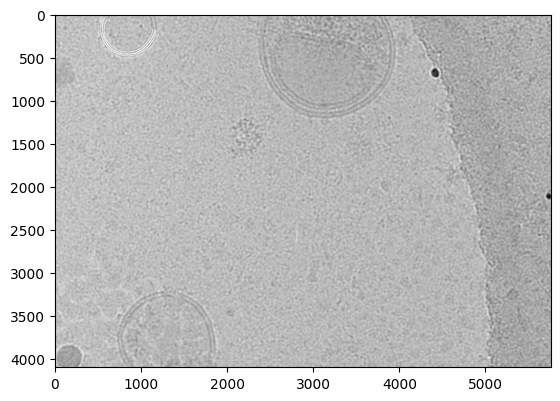

In [62]:
img_temp = np.copy(blurred_image)
img_temp_max = np.max(img_temp)
for spline in splines:
    for particle in spline:
        for i in range(-3, 4):
            for j in range(-3, 4):
                if particle[1] + i < img_temp.shape[0] and particle[0] + j < img_temp.shape[1]:
                    img_temp[(particle[1] + i, particle[0] + j)] = img_temp_max
plt.imshow(img_temp, cmap="gray")
plt.show()